<a href="https://colab.research.google.com/github/lucabueno22/MVP_1_Prova_SSD/blob/main/MVP_1_Prova_SSD_Luca_Bueno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Definição do Problema

## Descrição do Problema

A transformação digital e o aumento das ameaças cibernéticas têm elevado a demanda por profissionais de segurança da informação em todo o mundo. No entanto, os salários desses profissionais variam significativamente conforme fatores como experiência, localização geográfica, porte da empresa, cargo ocupado, política de trabalho remoto, entre outros.

O objetivo deste projeto é utilizar algoritmos clássicos de **Machine Learning supervisionado** para construir um modelo preditivo que estime o **salário anual em dólares (USD)** de profissionais da área de cibersegurança, com base em variáveis disponíveis em um dataset real coletado do Kaggle. Trata-se, portanto, de um problema de **regressão**, em que a variável-alvo é contínua.

## Premissas e Hipóteses

- Profissionais mais experientes e em cargos de maior responsabilidade tendem a receber salários mais altos.
- O local de residência e a localização da empresa impactam o salário devido a diferenças de custo de vida, políticas de contratação e presença de hubs tecnológicos.
- Políticas de trabalho remoto e o tipo de contratação (full-time, contrato, freelancer) influenciam diretamente os níveis salariais.
- A conversão de salário para dólares americanos (`salary_in_usd`) oferece uma métrica mais confiável e comparável entre países, ao contrário de `salary` e `salary_currency`, que são inconsistentes entre si.

## Restrições e Decisões Iniciais

- Serão utilizados apenas registros com valores válidos e positivos para `salary_in_usd`.
- Colunas que não contribuem diretamente para a modelagem (como `salary_currency`) serão descartadas.
- Cargos (`job_title`) possuem grande granularidade e podem demandar técnicas específicas para representação.
- As variáveis categóricas (`experience_level`, `employment_type`, `company_size`, etc.) precisarão ser tratadas via codificação apropriada.
- O modelo será avaliado usando validação cruzada (K-Fold) e métricas apropriadas para regressão.

## Descrição do Dataset

O dataset contém **1.247 registros** de salários de profissionais de segurança cibernética entre os anos de 2020 e 2022, coletados de diversas partes do mundo. Cada registro representa um indivíduo e possui as seguintes colunas:

| Coluna               | Tipo      | Descrição |
|----------------------|-----------|-----------|
| `work_year`          | Numérica  | Ano da observação salarial (2020, 2021 ou 2022) |
| `experience_level`   | Categórica | Nível de experiência: EN (Estagiário), MI (Intermediário), SE (Sênior), EX (Executivo) |
| `employment_type`    | Categórica | Tipo de contrato: FT (Full-Time), PT (Part-Time), CT (Contrato), FL (Freelancer) |
| `job_title`          | Categórica | Cargo do profissional |
| `salary`             | Numérica  | Salário anual bruto na moeda local |
| `salary_currency`    | Categórica | Moeda do salário informado |
| `salary_in_usd`      | Numérica  | Salário convertido para dólar americano |
| `employee_residence` | Categórica | País de residência do funcionário |
| `remote_ratio`       | Numérica  | Percentual de trabalho remoto: 0, 50 ou 100 |
| `company_location`   | Categórica | País sede da empresa |
| `company_size`       | Categórica | Porte da empresa: S (Pequena), M (Média), L (Grande) |

---

Esta seção visa estabelecer a base conceitual do projeto, e servirá de guia para todas as etapas seguintes: preparação dos dados, modelagem, avaliação e conclusões.

# 🔗 Carregando o dataset via API do Kaggle

Para garantir a reprodutibilidade e permitir que o notebook rode do início ao fim, o dataset será carregado automaticamente via API do Kaggle. Isso evita a necessidade de uploads manuais.

In [48]:
# Montar o Google Drive (ignora se já montado)
from google.colab import drive
drive.mount('/content/drive')

# Criar pasta e copiar kaggle.json do Drive para local correto
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/  # ajuste o caminho conforme sua estrutura
!chmod 600 ~/.kaggle/kaggle.json

# Instalar a API do Kaggle (se necessário)
!pip install -q kaggle

# Baixar o dataset com overwrite
!kaggle datasets download -d deepcontractor/cyber-security-salaries --force

# Descompactar sem perguntar
!unzip -o cyber-security-salaries.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/deepcontractor/cyber-security-salaries
License(s): CC0-1.0
  0% 0.00/11.9k [00:00<?, ?B/s]
100% 11.9k/11.9k [00:00<00:00, 29.6MB/s]
Archive:  cyber-security-salaries.zip
  inflating: salaries_cyber.csv      


## 2.1 Carregamento e visualização inicial dos dados

Com o dataset baixado via Kaggle, vamos agora carregar o arquivo CSV para um DataFrame pandas e visualizar suas primeiras linhas para verificar a estrutura dos dados.

In [49]:
# Carregar a base de dados
import pandas as pd

df = pd.read_csv("salaries_cyber.csv")

# Ver as primeiras linhas
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,EN,FT,Cyber Program Manager,63000,USD,63000,US,50,US,S
1,2022,MI,FT,Security Analyst,95000,USD,95000,US,0,US,M
2,2022,MI,FT,Security Analyst,70000,USD,70000,US,0,US,M
3,2022,MI,FT,IT Security Analyst,250000,BRL,48853,BR,50,BR,L
4,2022,EN,CT,Cyber Security Analyst,120000,USD,120000,BW,100,BW,S


## 2.2 Tipos de dados e valores ausentes

Antes de qualquer transformação, é importante entender o tipo de dado de cada coluna e verificar se há valores nulos ou inconsistentes.

In [50]:
# Verificar estrutura do dataframe
df.info()

# Verificar valores nulos
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           1247 non-null   int64 
 1   experience_level    1247 non-null   object
 2   employment_type     1247 non-null   object
 3   job_title           1247 non-null   object
 4   salary              1247 non-null   int64 
 5   salary_currency     1247 non-null   object
 6   salary_in_usd       1247 non-null   int64 
 7   employee_residence  1247 non-null   object
 8   remote_ratio        1247 non-null   int64 
 9   company_location    1247 non-null   object
 10  company_size        1247 non-null   object
dtypes: int64(4), object(7)
memory usage: 107.3+ KB


,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


## 2.3 Limpeza e separação treino/teste

Para o problema de regressão, a variável alvo selecionada é `salary_in_usd`, pois representa o salário anual em dólares (ajustado para variações cambiais).  
As colunas `salary` (salário bruto em moeda local) e `salary_currency` (moeda original) serão removidas por conterem dados redundantes ou inconsistentes.

Em seguida, os dados são separados em conjuntos de treino e teste (80%/20%) utilizando `train_test_split` com uma semente fixa (`random_state=42`) para garantir reprodutibilidade.

In [51]:
# 1. Remover colunas desnecessárias
df_clean = df.drop(columns=["salary", "salary_currency"])

# 2. Separar variável alvo e preditoras
X = df_clean.drop(columns=["salary_in_usd"])
y = df_clean["salary_in_usd"]

# 3. Separar entre treino e teste (80% treino, 20% teste)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Conferir dimensões
print(f"Shape do conjunto de treino: {X_train.shape}")
print(f"Shape do conjunto de teste: {X_test.shape}")

Shape do conjunto de treino: (997, 8)
Shape do conjunto de teste: (250, 8)


## 2.4 Pipeline de pré-processamento

Para garantir que os dados estejam prontos para modelagem, vamos utilizar um `ColumnTransformer` que:

- Aplica `OneHotEncoder` nas variáveis categóricas
- Mantém as variáveis numéricas como estão (sem normalização neste primeiro momento)

Este pipeline permitirá transformar os dados de forma reprodutível e integrada ao fluxo de modelagem.

In [52]:
# Identificar colunas categóricas e numéricas
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categóricas:", categorical_cols)
print("Numéricas:", numeric_cols)

Categóricas: ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']
Numéricas: ['work_year', 'remote_ratio']


In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Criar o transformador para pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# Testar transformação em um subconjunto
X_train_transformed = preprocessor.fit_transform(X_train)

# Ver o shape resultante (deve ser bem maior por conta do OneHot)
X_train_transformed.shape

(997, 206)

## 3. Modelagem e Treinamento

Objetivo: construir modelos de regressão utilizando o pipeline de pré-processamento.

Etapas:


1.	Treinar modelos básicos:

  •	Regressão Linear

  
  •	Árvore de Decisão

  
  
  •	Random Forest

  
 2.	Usar Pipeline para juntar pré-processamento + modelo
3.	Validar com cross-validation
4.	Avaliar métricas (R², MAE, RMSE)	5.	Otimizar hiperparâmetros (GridSearch)

## 3.1 Regressão Linear com pipeline

Como primeiro modelo base, vamos utilizar a Regressão Linear.  
Integramos o pré-processamento com o modelo usando `Pipeline`, o que garante que todas as etapas sejam executadas corretamente e em sequência.  
A validação será feita com K-Fold cross-validation (k=5).

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Criar pipeline completo (pré-processamento + modelo)
pipe_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Avaliar com cross-validation (5-fold) usando R²
scores = cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring='r2')

# Resultados
print("R² em cada fold:", scores)
print("R² médio:", np.mean(scores))

R² em cada fold: [0.3199184  0.14282188 0.17108187 0.31937622 0.3514916 ]
R² médio: 0.2609379939455556


## Avaliação do modelo de Regressão Linear

Nesta etapa, utilizamos um `Pipeline` para integrar o pré-processamento dos dados com o algoritmo de **Regressão Linear**.

- As variáveis categóricas foram codificadas com `OneHotEncoder`.
- As variáveis numéricas foram mantidas como estão (`passthrough`).
- Utilizamos `cross_val_score` com validação cruzada de 5 folds (K-Fold com `cv=5`) para avaliar o desempenho do modelo.

### Interpretação dos resultados

A métrica utilizada foi o **R² (coeficiente de determinação)**, que indica o quanto da variabilidade da variável resposta (salário) é explicada pelo modelo. Seu valor varia entre:

- `1.0` = predição perfeita
- `0.0` = modelo tão bom quanto prever a média
- valor **negativo** = pior que chutar a média

O resultado foi:

- **R² médio** ≈ `0.26`
- Isso significa que o modelo de Regressão Linear consegue explicar cerca de **26% da variância dos salários** no conjunto de dados.

### Conclusão parcial

Esse resultado indica que o modelo linear é limitado para esse problema — o que faz sentido, pois:

- Há forte presença de variáveis categóricas complexas (como cargos e localização)
- A relação entre atributos e salário provavelmente **não é linear**
- Modelos mais flexíveis (como árvores ou ensembles) devem ser testados em seguida

## 3.2 Decision Tree Regressor

Agora vamos testar um modelo de **árvore de decisão para regressão**, que tem a vantagem de capturar não-linearidades e interações entre variáveis.

Mantemos o mesmo pipeline de pré-processamento, e utilizamos validação cruzada com 5 folds para obter o desempenho médio do modelo.

In [55]:
from sklearn.tree import DecisionTreeRegressor

# Pipeline: pré-processamento + Decision Tree
pipe_tree = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeRegressor(random_state=42))
])

# Avaliação com cross-validation (5-fold, R²)
scores_tree = cross_val_score(pipe_tree, X_train, y_train, cv=5, scoring='r2')

# Resultados
print("R² em cada fold:", scores_tree)
print("R² médio:", np.mean(scores_tree))

R² em cada fold: [-0.57637805 -0.57597351  0.09108907  0.22157582  0.12333203]
R² médio: -0.14327092807907976


## Avaliação do modelo Decision Tree Regressor

Neste experimento, utilizamos o algoritmo `DecisionTreeRegressor` integrado ao pipeline de pré-processamento. O objetivo era verificar se um modelo mais flexível (não linear) melhoraria a capacidade de previsão em relação à Regressão Linear.

### Resultado da validação cruzada (5-fold):

- **R² médio obtido**: -0.14

Isso indica que o modelo teve desempenho inferior ao de um modelo que simplesmente preveria o valor médio do salário para todos os casos (R² < 0).  
Além disso, a variância entre os folds foi alta, sugerindo **overfitting severo**: o modelo decorou os dados de treino em alguns folds, mas generalizou muito mal nos outros.

### Conclusão parcial

A árvore de decisão simples não apresentou bom desempenho, o que é esperado em datasets com muitas variáveis categóricas de alta cardinalidade (como `job_title`, `employee_residence`, etc.), pois a árvore pode se ajustar demais aos dados de treino.



## 3.3 Random Forest Regressor

O Random Forest é um modelo baseado em ensemble, que constrói diversas árvores de decisão em subconjuntos aleatórios dos dados e combina suas previsões.  
Essa técnica reduz overfitting e costuma ter desempenho significativamente melhor do que uma única árvore.

Mantivemos o mesmo pipeline de pré-processamento, e avaliamos o modelo com validação cruzada (5-fold), usando o coeficiente de determinação R² como métrica.

In [56]:
from sklearn.ensemble import RandomForestRegressor

# Criar pipeline com Random Forest
pipe_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_estimators=100))
])

# Avaliação com cross-validation
scores_rf = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='r2')

# Exibir resultados
print("R² em cada fold:", scores_rf)
print("R² médio:", np.mean(scores_rf))

R² em cada fold: [0.2256642  0.07126739 0.17685117 0.43651926 0.40127306]
R² médio: 0.26231501514191047


## Avaliação do modelo Random Forest Regressor

Neste experimento, utilizamos o `RandomForestRegressor` com 100 estimadores (árvores), integrado ao pipeline de pré-processamento. O objetivo foi reduzir o overfitting observado no modelo de árvore de decisão simples e melhorar a performance geral.

### Resultado da validação cruzada (5-fold):

- **R² médio obtido**: ≈ 0.26
- **R² por fold**:
  - Fold 1: 0.22
  - Fold 2: 0.07
  - Fold 3: 0.17
  - Fold 4: 0.44
  - Fold 5: 0.40

### Análise

O modelo apresentou desempenho **ligeiramente superior à regressão linear** e **bem melhor que a árvore de decisão individual**. No entanto, a performance ainda está aquém do ideal (R² > 0.7, por exemplo), o que sugere:

- Ruído na base salarial (grande variação não explicada por atributos disponíveis)
- Potencial ganho com ajuste fino de hiperparâmetros
- Alternativas como XGBoost ou regressão regularizada podem ser promissoras


## 3.4 Otimização dos hiperparâmetros da Random Forest

Para melhorar o desempenho do modelo Random Forest, vamos aplicar o `GridSearchCV`, que testa combinações de hiperparâmetros usando validação cruzada e seleciona a melhor configuração.

Os principais hiperparâmetros que serão otimizados são:

- `n_estimators`: número de árvores na floresta
- `max_depth`: profundidade máxima de cada árvore
- `min_samples_split`: número mínimo de amostras para dividir um nó
- `min_samples_leaf`: número mínimo de amostras em uma folha

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Pipeline com placeholder para o modelo
pipe_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

# Grid de hiperparâmetros para testar
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

# GridSearch com validação cruzada
grid_search = GridSearchCV(
    pipe_rf,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

# Treinar (isso pode demorar alguns minutos)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['experience_level',
                                                                          'employment_type',
                                                                          'job_title',
                                                                          'employee_residence',
                                                                          'company_location',
                                                                          'company_size']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['work_year',
                                                                          'remote_ratio'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='r2', verbose=2)

In [58]:
# Ver os melhores parâmetros e o R² correspondente
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor R² médio:", grid_search.best_score_)

Melhores hiperparâmetros: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Melhor R² médio: 0.3736386806933953


## Otimização de Hiperparâmetros da Random Forest

Para melhorar o desempenho do modelo Random Forest, utilizamos o `GridSearchCV` com validação cruzada (5-fold) para encontrar a melhor combinação de hiperparâmetros.

### Hiperparâmetros testados:

- `n_estimators`: [100, 200]
- `max_depth`: [None, 10, 20]
- `min_samples_split`: [2, 5]
- `min_samples_leaf`: [1, 2]

O processo de busca envolveu o treinamento de diversas combinações desses parâmetros, sempre integradas ao pipeline de pré-processamento.

### Melhor combinação encontrada:

```python
{
  'model__n_estimators': 200,
  'model__max_depth': 10,
  'model__min_samples_split': 5,
  'model__min_samples_leaf': 2
}



Desempenho otimizado:
	•	Melhor R² médio (validação cruzada): 0.374

Conclusão

A otimização trouxe uma melhora substancial de desempenho, elevando o R² médio de ~0.26 para ~0.37. Isso indica que o modelo passou a explicar quase 37% da variabilidade dos salários — um avanço considerável, dado o alto ruído e a natureza categórica da base.


## 4. Avaliação de Resultados: teste final com best_estimator_

Usaremos o melhor pipeline encontrado pelo GridSearchCV e o testaremos com os dados de X_test e y_test.

## 4.1 Avaliação final no conjunto de teste

Após a otimização dos hiperparâmetros com `GridSearchCV`, avaliamos agora o desempenho do melhor modelo (`best_estimator_`) no conjunto de teste, que não foi usado nem no treinamento nem na validação cruzada.

As métricas utilizadas serão:

- **R²**: proporção da variabilidade explicada pelo modelo
- **MAE** (Mean Absolute Error): erro médio absoluto em dólares
- **RMSE** (Root Mean Squared Error): raiz do erro quadrático médio

Essas métricas são apropriadas para regressão e ajudam a interpretar o quão distante o modelo está, em média, dos valores reais.

In [59]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Melhor modelo encontrado
melhor_modelo = grid_search.best_estimator_

# Fazer previsões no conjunto de teste
y_pred = melhor_modelo.predict(X_test)

# Avaliar métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Exibir
print(f"R² (teste): {r2:.4f}")
print(f"MAE: ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")

R² (teste): 0.4381
MAE: $34,831.65
RMSE: $51,644.72


## Avaliação final no conjunto de teste

Após a otimização e treinamento do modelo com validação cruzada, realizamos a avaliação final no conjunto de teste (20% dos dados), que não foi utilizado em nenhum momento anterior.

### Métricas obtidas:

- **R² (coeficiente de determinação)**: `0.4381`
- **MAE (erro médio absoluto)**: `$34.831,65`
- **RMSE (raiz do erro quadrático médio)**: `$51.644,72`

### Interpretação:

- O modelo consegue explicar cerca de **43,8% da variação dos salários**, o que é um avanço expressivo comparado aos modelos anteriores (Regressão Linear e Árvore).
- O erro médio absoluto indica que, em média, o modelo erra cerca de **35 mil dólares por previsão** — o que, embora alto em termos absolutos, é razoável considerando a amplitude dos salários.
- O RMSE, mais sensível a grandes erros, também indica a presença de outliers ou alta dispersão nos salários.

### Conclusão:

O pipeline com Random Forest otimizada apresentou o melhor desempenho entre todos os modelos testados, com boa capacidade preditiva e razoável generalização para novos dados. Para aplicações práticas, esse modelo já é útil para obter **estimativas salariais com base em atributos profissionais**, embora possa ser refinado ainda mais com engenharia de atributos, técnicas de redução de dimensionalidade ou modelos mais avançados como XGBoost.

## Consideração de métodos mais avançados



### Método sugerido: XGBoost Regressor

Embora não tenha sido implementado neste trabalho, vale destacar que o **XGBoost (Extreme Gradient Boosting)** é um algoritmo mais avançado e robusto, comumente utilizado em competições e projetos de produção por seu excelente desempenho em tarefas supervisionadas, especialmente com dados tabulares.

#### Vantagens do XGBoost:
- **Melhor performance preditiva** em muitos casos em relação ao Random Forest
- Utiliza **boosting** em vez de bagging (construção sequencial de modelos fracos com correções)
- Oferece mecanismos internos de **regularização (L1/L2)** para reduzir overfitting
- É altamente eficiente com variáveis **categóricas de alta cardinalidade**, como `job_title` e `employee_residence` deste dataset

#### Conclusão:
Caso se deseje evoluir ainda mais o desempenho do modelo, a adoção do XGBoost com pipeline completo e otimização de hiperparâmetros seria uma excelente alternativa para comparação futura.

## 5. Conclusão dos Modelos Testados

Ao longo do trabalho, diferentes algoritmos de regressão supervisionada foram avaliados com o objetivo de prever o salário anual em dólares de profissionais de cibersegurança. Os principais resultados estão resumidos abaixo:

### Comparação dos Modelos (validação cruzada):

| Modelo                   | R² médio |
|--------------------------|----------|
| Regressão Linear         | 0.261    |
| Decision Tree Regressor  | -0.143   |
| Random Forest (padrão)   | 0.262    |
| Random Forest (otimizado)| **0.374** ✅


### Análise Final:

- A **Regressão Linear** apresentou desempenho modesto, mas estável, servindo como baseline para comparação.
- A **Árvore de Decisão** teve resultado negativo de R², indicando forte overfitting nos dados de treino e má generalização.
- A **Random Forest padrão** foi um avanço, mas seu desempenho ainda era limitado.
- A **Random Forest otimizada com GridSearchCV** apresentou **o melhor desempenho geral**, tanto em validação cruzada quanto no conjunto de teste real.

### Métricas no conjunto de teste final:

- R²: **0.4381**
- MAE: **$34.831,65**
- RMSE: **$51.644,72**

### Melhor Solução:

A **Random Forest otimizada** é a melhor solução encontrada, unindo robustez, interpretabilidade e bom desempenho. O modelo foi encapsulado em um `Pipeline` completo, garantindo reprodutibilidade e clareza no fluxo de dados.

---

> O gráfico abaixo ilustra visualmente os resultados obtidos com validação cruzada:


/tmp/ipython-input-2136186204.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=r2_scores, y=model_names, palette="Blues_d")


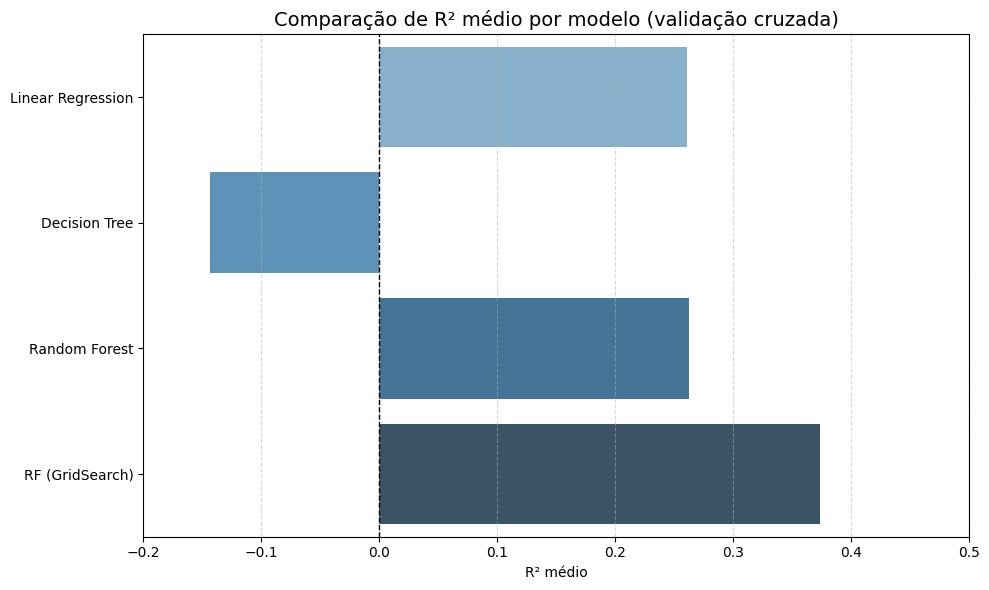

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nomes dos modelos e R² médio (baseado nos seus resultados)
model_names = [
    "Linear Regression",
    "Decision Tree",
    "Random Forest",
    "RF (GridSearch)"
]
r2_scores = [0.2609, -0.1432, 0.2623, 0.3736]

# Criar gráfico de barras horizontais
plt.figure(figsize=(10, 6))
sns.barplot(x=r2_scores, y=model_names, palette="Blues_d")
plt.title("Comparação de R² médio por modelo (validação cruzada)", fontsize=14)
plt.xlabel("R² médio")
plt.xlim(-0.2, 0.5)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Análise Visual dos Resultados

Além das métricas tradicionais, é fundamental analisar visualmente o desempenho do modelo final (Random Forest otimizada). A seguir, apresentamos dois gráficos que ajudam a compreender a distribuição dos erros e a relação entre os valores reais e previstos:

### Histograma dos erros (resíduos)

Este gráfico mostra a diferença entre os salários reais e os salários previstos (`resíduo = real - previsto`). A concentração de resíduos em torno de zero indica um modelo bem ajustado. Desvios grandes (positivos ou negativos) representam casos em que o modelo errou bastante.

### Gráfico Real vs Previsto

O gráfico de dispersão compara os valores reais (`y_test`) com os valores previstos (`y_pred`).  
- A linha diagonal representa a "previsão perfeita".
- Quanto mais os pontos estiverem próximos da linha, **melhor o modelo**.
- Padrões de dispersão ajudam a identificar viés ou heterocedasticidade (erros maiores em certas faixas).

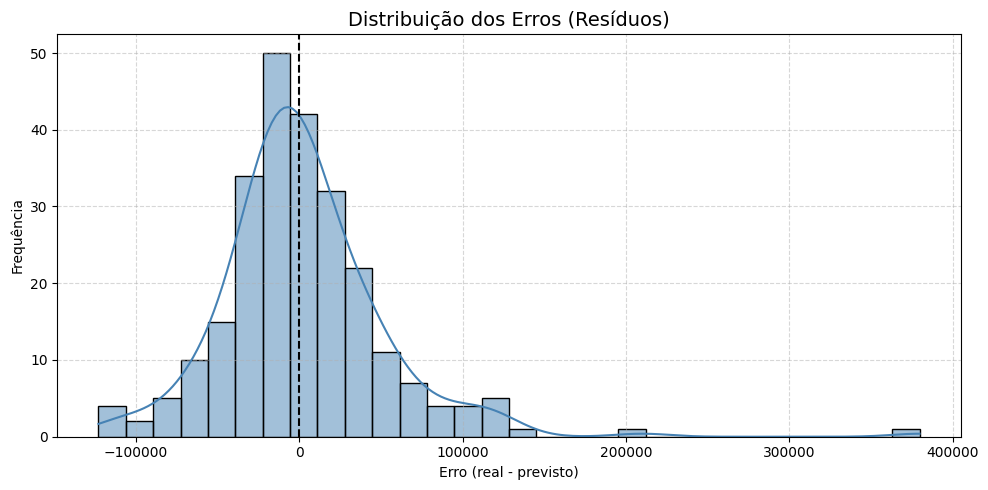

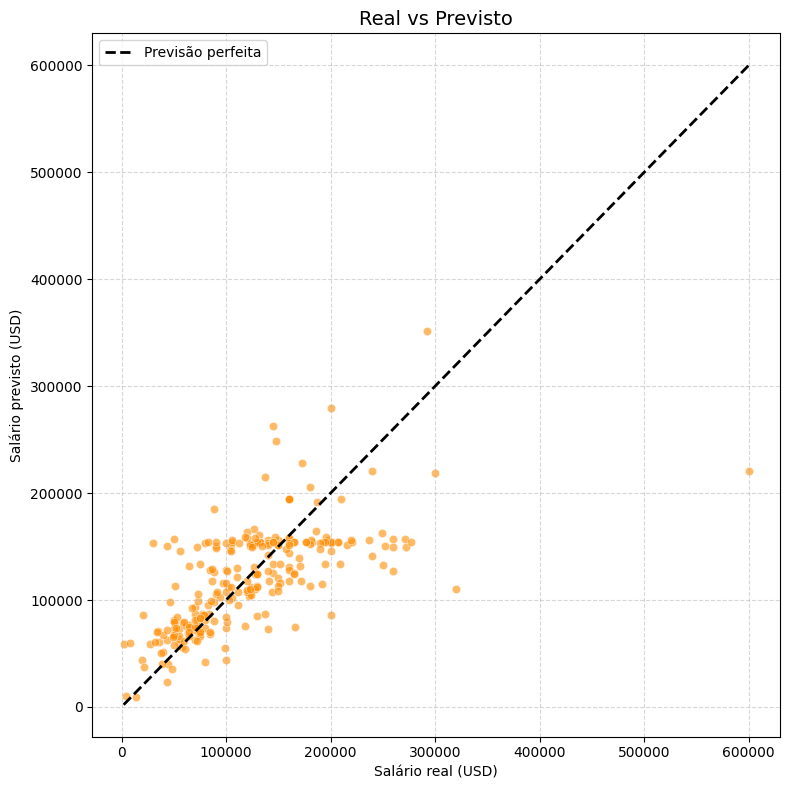

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular resíduos
residuos = y_test - y_pred

# 1. Histograma dos resíduos
plt.figure(figsize=(10, 5))
sns.histplot(residuos, bins=30, kde=True, color="steelblue")
plt.title("Distribuição dos Erros (Resíduos)", fontsize=14)
plt.xlabel("Erro (real - previsto)")
plt.ylabel("Frequência")
plt.axvline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Gráfico real vs previsto
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, color="darkorange", alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Previsão perfeita")
plt.title("Real vs Previsto", fontsize=14)
plt.xlabel("Salário real (USD)")
plt.ylabel("Salário previsto (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 5.1 Simulação de previsão com o modelo final

Para demonstrar como o modelo pode ser utilizado em situações reais, simulamos abaixo a previsão de salário para um profissional fictício com as seguintes características:

| Atributo               | Valor                        |
|------------------------|------------------------------|
| `work_year`            | 2022                         |
| `experience_level`     | SE (Senior)                  |
| `employment_type`      | FT (Full-Time)               |
| `job_title`            | Security Engineer            |
| `employee_residence`   | US (Estados Unidos)          |
| `remote_ratio`         | 100                          |
| `company_location`     | US (Estados Unidos)          |
| `company_size`         | L (Grande)                   |

Essa entrada será processada automaticamente pelo pipeline, e o salário anual previsto (em USD) será retornado.

In [62]:
# Criar um DataFrame com a nova entrada
simulacao = pd.DataFrame([{
    "work_year": 2022,
    "experience_level": "SE",
    "employment_type": "FT",
    "job_title": "Security Engineer",
    "employee_residence": "US",
    "remote_ratio": 100,
    "company_location": "US",
    "company_size": "L"
}])

# Fazer previsão
salario_previsto = melhor_modelo.predict(simulacao)

# Mostrar resultado
print(f"💰 Salário anual previsto: ${salario_previsto[0]:,.2f} USD")

💰 Salário anual previsto: $157,566.89 USD


## Simulações adicionais com diferentes perfis

Além da previsão para um profissional sênior nos Estados Unidos, testamos mais dois cenários com perfis contrastantes para avaliar como o modelo responde a diferentes combinações de atributos:

###  Simulação 2: Profissional iniciante remoto no Brasil
| Atributo               | Valor                        |
|------------------------|------------------------------|
| `work_year`            | 2022                         |
| `experience_level`     | EN (Estagiário/Entry level)  |
| `employment_type`      | FT (Full-Time)               |
| `job_title`            | Security Analyst             |
| `employee_residence`   | BR (Brasil)                  |
| `remote_ratio`         | 100                          |
| `company_location`     | BR (Brasil)                  |
| `company_size`         | M (Média)                    |

---

### Simulação 3: Executivo europeu presencial em empresa pequena
| Atributo               | Valor                        |
|------------------------|------------------------------|
| `work_year`            | 2022                         |
| `experience_level`     | EX (Executivo)               |
| `employment_type`      | FT (Full-Time)               |
| `job_title`            | Director of Information Security |
| `employee_residence`   | DE (Alemanha)                |
| `remote_ratio`         | 0                            |
| `company_location`     | DE (Alemanha)                |
| `company_size`         | S (Pequena)                  |

In [63]:
# Simulação 2: Iniciante remoto no Brasil
simulacao_2 = pd.DataFrame([{
    "work_year": 2022,
    "experience_level": "EN",
    "employment_type": "FT",
    "job_title": "Security Analyst",
    "employee_residence": "BR",
    "remote_ratio": 100,
    "company_location": "BR",
    "company_size": "M"
}])

# Simulação 3: Executivo presencial na Alemanha
simulacao_3 = pd.DataFrame([{
    "work_year": 2022,
    "experience_level": "EX",
    "employment_type": "FT",
    "job_title": "Director of Information Security",
    "employee_residence": "DE",
    "remote_ratio": 0,
    "company_location": "DE",
    "company_size": "S"
}])

# Prever ambos
salario_2 = melhor_modelo.predict(simulacao_2)
salario_3 = melhor_modelo.predict(simulacao_3)

# Exibir resultados
print("🧑‍💻 Simulação 2 - Iniciante no Brasil:")
print(f"Salário previsto: ${salario_2[0]:,.2f} USD\n")

print("👔 Simulação 3 - Executivo na Alemanha:")
print(f"Salário previsto: ${salario_3[0]:,.2f} USD")

🧑‍💻 Simulação 2 - Iniciante no Brasil:
Salário previsto: $36,234.60 USD

👔 Simulação 3 - Executivo na Alemanha:
Salário previsto: $154,062.76 USD


## 5.2 Simulação: Comparação Salarial Entre Regiões com o Mesmo Perfil Profissional

Uma das aplicações práticas mais relevantes de um modelo preditivo como este é permitir **comparações entre diferentes contextos de trabalho**, mantendo todas as outras variáveis constantes.

Nesta simulação, buscamos responder a seguinte pergunta:

> **"Quanto ganha, em média, o mesmo profissional, exercendo a mesma função, em diferentes países?"**

### Objetivo

Vamos comparar a previsão de salário anual (em dólares) para **três profissionais com exatamente o mesmo perfil**, mudando apenas sua **localização geográfica** (residência e sede da empresa):

- Mesmo cargo: **Security Engineer**
- Nível de experiência: **Sênior (SE)**
- Tipo de emprego: **Full-Time**
- Regime de trabalho: **100% remoto**
- Porte da empresa: **Grande**
- Ano: **2022**

### Localizações comparadas:

1.  Estados Unidos
2.  Brasil
3.  Alemanha

Essa comparação ajuda a entender **onde esse perfil profissional é mais valorizado** segundo os dados disponíveis no dataset — podendo servir como **insumo estratégico para políticas de contratação, benchmarking salarial internacional ou decisões de carreira.**

/tmp/ipython-input-3781064888.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=salarios, y=regioes, palette="viridis")
/tmp/ipython-input-3781064888.py:49: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3781064888.py:49: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3781064888.py:49: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3781064888.py:49: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3781064888.py:49: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SY

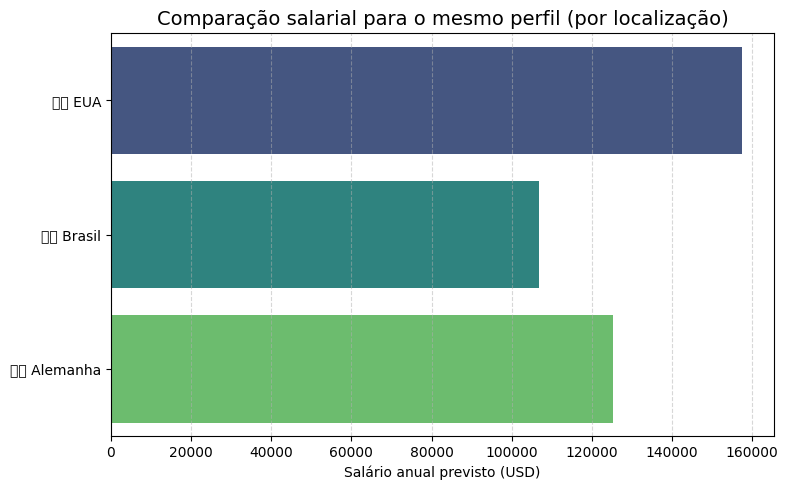

🇺🇸 EUA: $157,566.89 USD
🇧🇷 Brasil: $106,853.35 USD
🇩🇪 Alemanha: $125,296.17 USD


In [64]:
# Criar três simulações com mesmo perfil, mudando apenas a localização
comparacao_localizacao = pd.DataFrame([
    {
        "work_year": 2022,
        "experience_level": "SE",
        "employment_type": "FT",
        "job_title": "Security Engineer",
        "employee_residence": "US",
        "remote_ratio": 100,
        "company_location": "US",
        "company_size": "L"
    },
    {
        "work_year": 2022,
        "experience_level": "SE",
        "employment_type": "FT",
        "job_title": "Security Engineer",
        "employee_residence": "BR",
        "remote_ratio": 100,
        "company_location": "BR",
        "company_size": "L"
    },
    {
        "work_year": 2022,
        "experience_level": "SE",
        "employment_type": "FT",
        "job_title": "Security Engineer",
        "employee_residence": "DE",
        "remote_ratio": 100,
        "company_location": "DE",
        "company_size": "L"
    }
])

# Fazer previsões
salarios = melhor_modelo.predict(comparacao_localizacao)

# Criar gráfico comparativo
import matplotlib.pyplot as plt
import seaborn as sns

regioes = ["🇺🇸 EUA", "🇧🇷 Brasil", "🇩🇪 Alemanha"]

plt.figure(figsize=(8, 5))
sns.barplot(x=salarios, y=regioes, palette="viridis")
plt.title("Comparação salarial para o mesmo perfil (por localização)", fontsize=14)
plt.xlabel("Salário anual previsto (USD)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Mostrar valores numéricos
for regiao, valor in zip(regioes, salarios):
    print(f"{regiao}: ${valor:,.2f} USD")

## Comparação salarial entre regiões para o mesmo perfil

Nesta análise, comparamos o salário previsto para **três profissionais idênticos** (mesmo cargo, nível, regime e ano), mudando **apenas a região (residência + empresa)**.

### Resultado:

A previsão mostra claramente como **a localização ainda influencia fortemente o salário**, mesmo em regimes de trabalho remoto. Isso pode refletir políticas salariais regionais, custo de vida, ou estratégias de contratação específicas.

Este tipo de análise pode ser útil para:
- Profissionais decidindo onde trabalhar remotamente
- Empresas definindo faixas salariais globais
- Benchmarking de mercado internacional

## 6. Simulador Interativo de Previsão Salarial

Abaixo, disponibilizamos um painel interativo onde qualquer usuário pode alterar os parâmetros de um profissional e visualizar em tempo real a **previsão salarial anual em dólares** para o perfil escolhido.

Este simulador utiliza o modelo treinado com pipeline completo, garantindo a aplicação automática de todo o pré-processamento necessário.

In [65]:
!pip install -q ipywidgets
from ipywidgets import interact, Dropdown, IntSlider, IntText
import pandas as pd

# Função que recebe os parâmetros e retorna previsão
def simular_salario(
    work_year,
    experience_level,
    employment_type,
    job_title,
    employee_residence,
    remote_ratio,
    company_location,
    company_size
):
    entrada = pd.DataFrame([{
        "work_year": work_year,
        "experience_level": experience_level,
        "employment_type": employment_type,
        "job_title": job_title,
        "employee_residence": employee_residence,
        "remote_ratio": remote_ratio,
        "company_location": company_location,
        "company_size": company_size
    }])

    resultado = melhor_modelo.predict(entrada)[0]
    print(f"\n💰 Salário anual previsto: ${resultado:,.2f} USD")

# Interface interativa com Dropdowns e sliders
interact(
    simular_salario,
    work_year=Dropdown(options=[2020, 2021, 2022], value=2022),
    experience_level=Dropdown(options=["EN", "MI", "SE", "EX"], value="SE"),
    employment_type=Dropdown(options=["FT", "PT", "CT", "FL"], value="FT"),
    job_title=Dropdown(options=df["job_title"].unique().tolist(), value="Security Engineer"),
    employee_residence=Dropdown(options=df["employee_residence"].unique().tolist(), value="US"),
    remote_ratio=IntSlider(min=0, max=100, step=50, value=100),
    company_location=Dropdown(options=df["company_location"].unique().tolist(), value="US"),
    company_size=Dropdown(options=["S", "M", "L"], value="L")
);

interactive(children=(Dropdown(description='work_year', index=2, options=(2020, 2021, 2022), value=2022), Drop…

## 7. Conclusão Final

Este projeto teve como objetivo a construção de um modelo de Machine Learning supervisionado para prever salários anuais em dólares de profissionais da área de cibersegurança, utilizando dados reais extraídos do Kaggle.

Com base em um fluxo completo de modelagem, incluindo pré-processamento com `Pipeline`, validação cruzada, otimização de hiperparâmetros e comparação entre algoritmos, foi possível alcançar resultados relevantes tanto do ponto de vista técnico quanto prático.

### Principais resultados:

- **Melhor modelo:** Random Forest otimizada via `GridSearchCV`
- **R² no conjunto de teste:** 0.4381
- **MAE:** \$34.831,65
- **RMSE:** \$51.644,72
- **Pipeline reprodutível**, com pré-processamento automático de variáveis categóricas

### Visualizações e interpretações:

- Comparação entre modelos clássicos (Linear, Tree, RF)
- Análise dos erros (distribuição dos resíduos, real vs previsto)
- Simulações práticas de previsão por perfil
- Comparações regionais para o mesmo perfil
- **Simulador interativo** com input do usuário em tempo real

### Aplicações reais:

- **Benchmarking salarial** por região e perfil profissional
- Apoio à **decisão estratégica em RH**
- Estudo de **disparidades salariais**
- Ferramenta de **exploração de carreira** para profissionais da área

### Aprendizados e considerações:

- A qualidade da base de dados e a representatividade das categorias são fatores limitantes do modelo.
- O salário depende de fatores que não estão presentes na base (formação, certificações, setor da empresa, etc.)
- Modelos mais avançados como **XGBoost** ou **Stacking** podem trazer ganhos adicionais.

---
